# FENICS SOLVER

### Import needed packages 

In [1]:
# Get the libraries
import fenics as fn
import numpy as np
import sympy as sym
import scipy as sc
from scipy import constants
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm #Colormap
import meshio as mio
import mshr as msr

#### Recangle mesh representing cell
#### Finite Elements for electrical potential and ion concentration
#### Simulation domain


In [2]:
#set parameters
q  = constants.value('elementary charge')           #C
T  = 273      #K
k  = constants.value('Boltzmann constant')          #J/K
e0 = constants.value('atomic unit of permittivity') #F/m
er = 110 #epsilonR e.g. h2so4
D  = 1 #diff
z  = 1 #charge e.g. Mg2+ 

alpha = 1#e0 * er 
beta  = z 
gamma = D
delta = 1#(D * q * z)/(k * T)

In [3]:
# define mesh and define function space
X    = 500  #x-limit
Y    = 500  #y-limit
NX   = 50  #x-steps
NY   = NX  #y-steps
M    = 2   #species

mesh = fn.RectangleMesh(fn.Point(-X, -Y), fn.Point(X, Y), NX, NY)

Poly    = fn.FiniteElement('Lagrange', mesh.ufl_cell(),2)
Multi   = fn.FiniteElement('Real', mesh.ufl_cell(), 0)
ElemP   = [Poly] * (M+1) 
ElemR   = [Multi] * (M)
Elem    = [ElemP + ElemR][0]
Mixed   = fn.MixedElement(Elem)
V       = fn.FunctionSpace(mesh, Mixed)


Poisson equation PE:
    $$ \nabla ( \epsilon_0 \epsilon_r \nabla \Phi) = \rho = zFc $$
Nernst-Planck equation NPE:
    $$ \nabla (-D \nabla c - D z f c \nabla \Phi ) = 0 $$
Test functions:
    $$ v,w \in V $$
Raise generalized solution:
    $$ \int(\epsilon_0 \epsilon_r \nabla \Phi) * \nabla v *dx = \int z F c * v * dx $$
    $$ \int(-D \nabla c - D z f c \nabla \Phi ) * \nabla w *dx = 0$$
    
Establish generalized PNP system:
    $$ \int \alpha \nabla \Phi * v * dx - \int \beta c * v *dx - \int(\gamma \nabla c - \delta c \nabla \Phi ) * w *dx $$

In [4]:
# define potentials and concentrations
u_GND  = fn.Expression('0', degree=2)          #Ground
u_DD   = fn.Expression('0.5', degree=2)          #pontential
c_INIT = fn.Expression('0.000001', degree=2)     #concentration on ground
c_avg  = fn.Expression('0.0001', degree=2)    #average concentration
c_NULL = fn.Expression('0.0001', degree=2)

# define boundaries
def boundaryGND(x, on_boundary):
    tol=1e-12
    return ((x[1] < -400 + tol)) 
def boundaryHigh(x, on_boundary):
    tol=1e-12
    return (x[1] > pow(x[0]/5,2)  - tol)

# set boundary conditions
GammaGND  = fn.DirichletBC(V.sub(0), u_GND, boundaryGND)  # ground potential at straight electrode
GammaHigh = fn.DirichletBC(V.sub(0), u_DD, boundaryHigh)  # high potential at shaped electrode
GammaC_GND    = []
GammaC_GND += [fn.DirichletBC(V.sub(i+1) , c_INIT, boundaryGND) for i in range(M)] # given concentration at straight electrode
GammaC_HIGH    = []
GammaC_HIGH += [fn.DirichletBC(V.sub(i+1) , c_avg, boundaryHigh) for i in range(M)] # given concentration at straight electrode
# create list of boundary conditions 
bcs=[GammaGND,GammaHigh,*GammaC_GND]#,*GammaC_HIGH]


# define problem
UC    = fn.Function(V)
uc    = fn.split(UC)                        # trial function potential concentration lagrange multi
u, c, lam = uc[0], uc[1:M+1], uc[M+1:]

VW    = fn.TestFunctions(V)                          # test function potential concentration lagrange multi                     
v, w, mu = VW[0], VW[1:M+1], VW[M+1:]

# changing concentrations charges
Rho = 0
for i in range(M):
    if i%2:
        Rho += -c[i]
    else:
        Rho += c[i]

PoissonLeft     = (fn.dot(alpha*fn.grad(u), fn.grad(v)))*fn.dx                    # weak solution Poisson left
PoissonRight    = -(Rho)*beta*v*fn.dx                                  # weak solution Poisson right
NernstPlanck    = 0
for i in range(M):
    if i%2:
        NernstPlanck += fn.dot(-gamma*fn.grad(c[i]) + c[i]*delta*fn.grad(u),fn.grad(w[i]))*fn.dx     # weak solution Nernst-Planck 
    else:
        NernstPlanck += fn.dot(-gamma*fn.grad(c[i]) - c[i]*delta*fn.grad(u),fn.grad(w[i]))*fn.dx     # weak solution Nernst-Planck

constraint = 0
for i in range(M):
    constraint += lam[i] * w[i] * fn.dx + (c[i] - c_avg) * mu[i] * fn.dx            #constraint a la hoermann
    
        
PNP_xy     = PoissonLeft + PoissonRight + NernstPlanck + constraint        # PNP system
 

In [5]:
# Compute solution
fn.solve(PNP_xy == 0, UC, bcs) # solve function

In [6]:
%matplotlib notebook
x,y=mesh.coordinates().T
X=x.reshape(NX+1,NY+1)
Y=y.reshape(NX+1,NY+1)

<IPython.core.display.Javascript object>


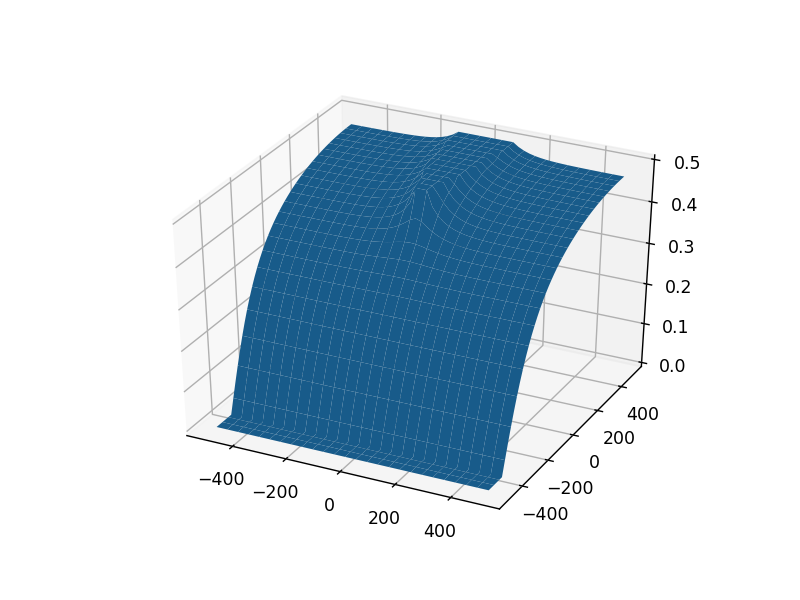

<IPython.core.display.Javascript object>


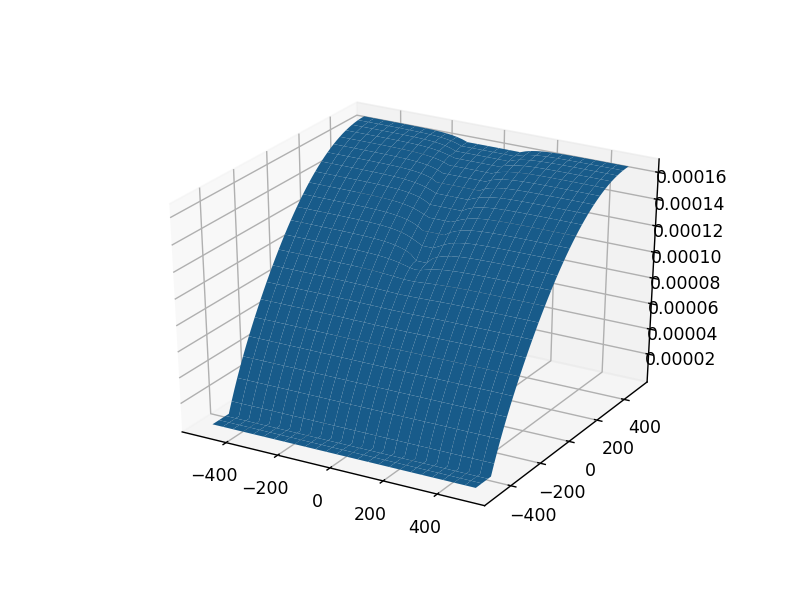

<IPython.core.display.Javascript object>


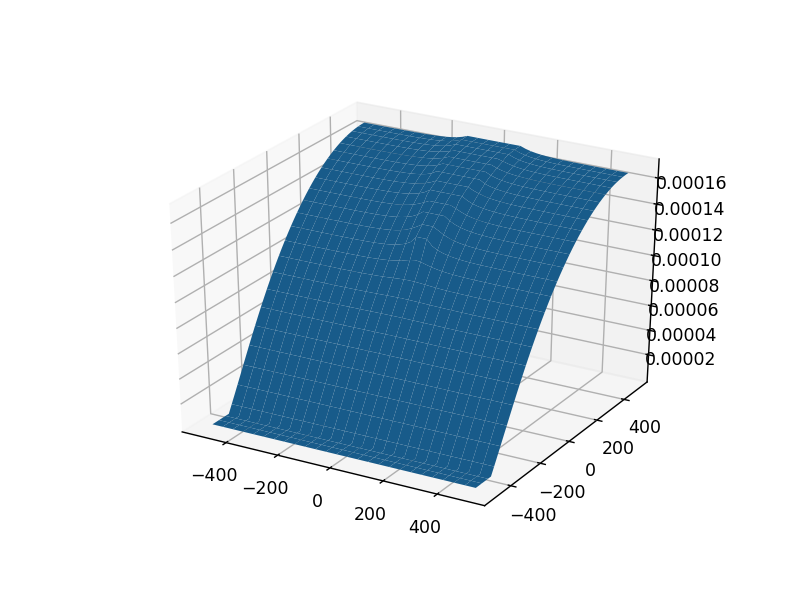

In [7]:
w_xy = np.array([UC(xy) for xy in mesh.coordinates()])
W_xy = w_xy.reshape((NX+1),(NY+1),M+1+M)
U_xy = W_xy[:,:,0]
C_xys = W_xy[:,:,1:]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,U_xy)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,C_xys[:,:,0])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,C_xys[:,:,1])


In [8]:
def colormap(array):
    fig = plt.figure()
    ax = fig.add_subplot()
    #cbar = fig.colorbar()
    ax.imshow(array, cmap="viridis")

In [9]:
def contour(array):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.contour(array)

<IPython.core.display.Javascript object>


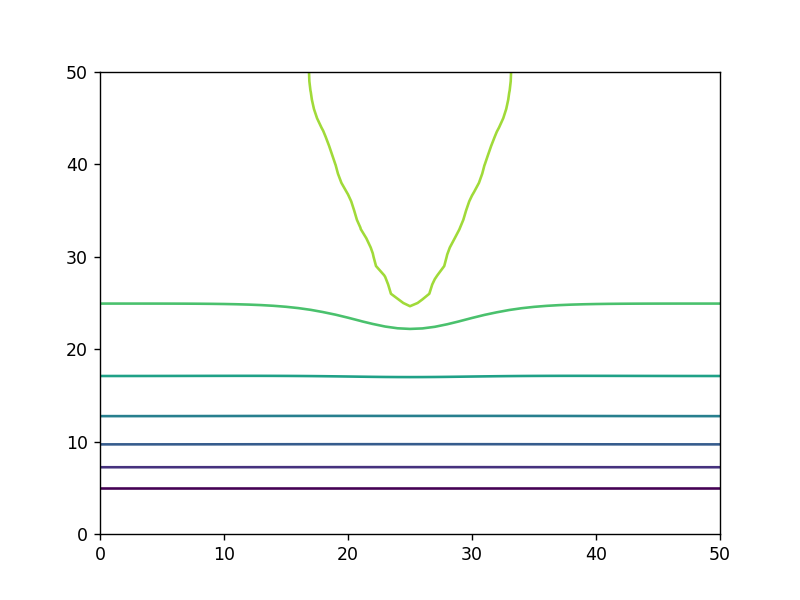

In [10]:
contour(U_xy)

<IPython.core.display.Javascript object>


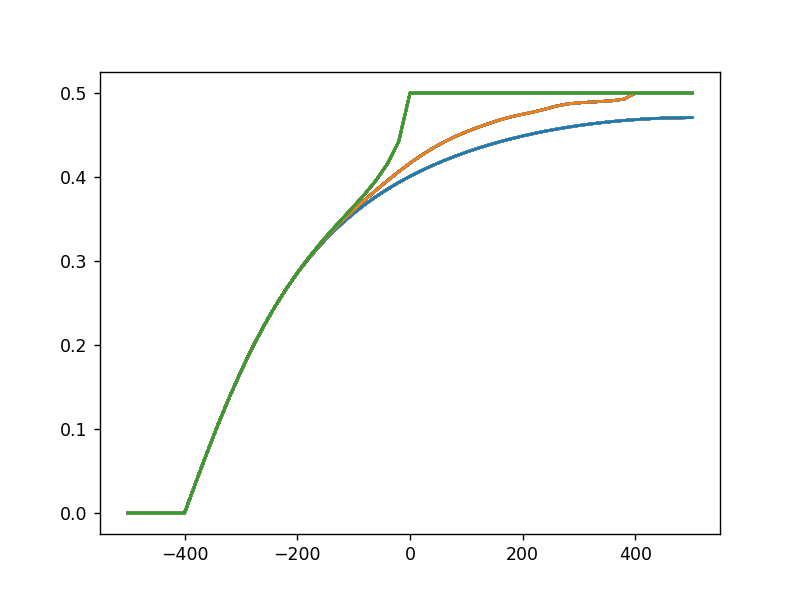

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Y,U_xy[::,10])
ax.plot(Y,U_xy[::,20])
ax.plot(Y,U_xy[::,25])

<IPython.core.display.Javascript object>


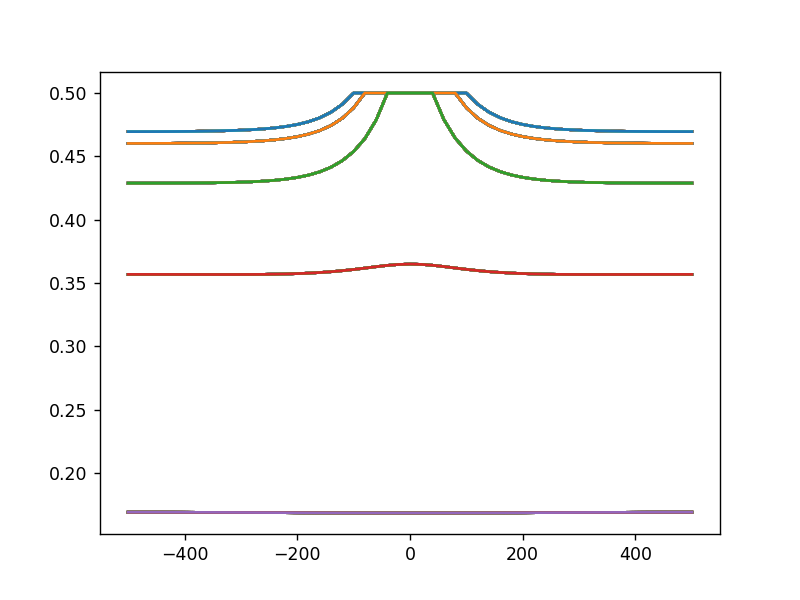

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Y,U_xy[50])
ax.plot(Y,U_xy[40])
ax.plot(Y,U_xy[30])
ax.plot(Y,U_xy[20])
ax.plot(Y,U_xy[10])